In [2]:
import biom
import pandas as pd
import numpy as np
from functools import partial

from skbio.diversity.beta import unweighted_unifrac
from skbio.diversity import beta_diversity
from skbio.diversity._util import _vectorize_counts_and_tree as vectorize_counts_and_tree
from skbio import TreeNode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

table = biom.load_table('../Data/amplicon/16s_subset.biom')
metadata = pd.read_table('../Data/sample.tsv', index_col=0)

# subset the table down for the sake of the tutorial
abundance_data = table.to_dataframe().T
md = metadata.loc[abundance_data.index]
tree = TreeNode.read('../Data/amplicon/16s_subset.nwk')

In this tutorial, we will go over best practices when training classifiers, as well as how to use scikit-bios functions to build customized
classifiers that can leverage biological domain knowledge, such as phylogenetic trees.

In [3]:
ids = abundance_data.index
taxa = abundance_data.columns
data = abundance_data.values
unifrac_dm = beta_diversity("unweighted_unifrac", data, ids, tree=tree, taxa=taxa)

dist_mat = unifrac_dm.data
labels = LabelEncoder().fit_transform(md['empo_1'])

## Unifrac

In [4]:
# we will use the first entries in the table for training,
# and the rest for testing
n_train  = len(md) * 8 // 10 
# the upper left block is the pairwise distances between training samples
train_X = dist_mat[:n_train, :n_train]
train_y = labels[:n_train]
# entry X_ij in the lower left block contains distance
# between test sample i and training sample j.
test_X = dist_mat[n_train:, :n_train]
test_y = labels[n_train:]

In [5]:
kneigh = KNeighborsClassifier(n_neighbors=2, metric='precomputed')
kneigh.fit(train_X, train_y)
test_pred = kneigh.predict(test_X)

Text(50.722222222222214, 0.5, 'Truth')

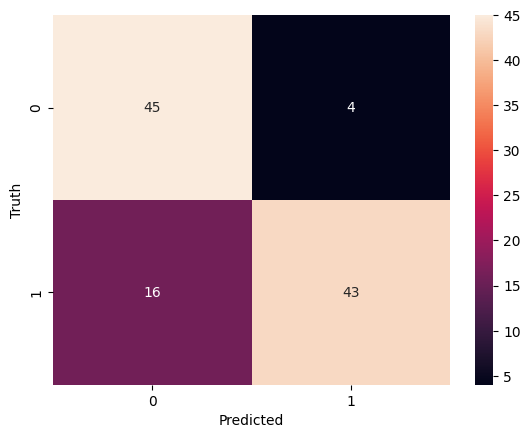

In [6]:
cm = confusion_matrix(test_y, test_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Random Forests

In [7]:
phylo_data = vectorize_counts_and_tree(abundance_data, taxa, tree)[0]

In [12]:
# we will use the first entries in the table for training,
# and the rest for testing
n_train  = len(md) * 8 // 10 
# the upper left block is the pairwise distances between training samples
train_X = phylo_data[:n_train]
train_y = labels[:n_train]
# entry X_ij in the lower left block contains distance
# between test sample i and training sample j.
test_X = phylo_data[n_train:]
test_y = labels[n_train:]

In [15]:
rf = RandomForestClassifier()
rf.fit(train_X, train_y)
test_pred = rf.predict(test_X)

Text(50.722222222222214, 0.5, 'Truth')

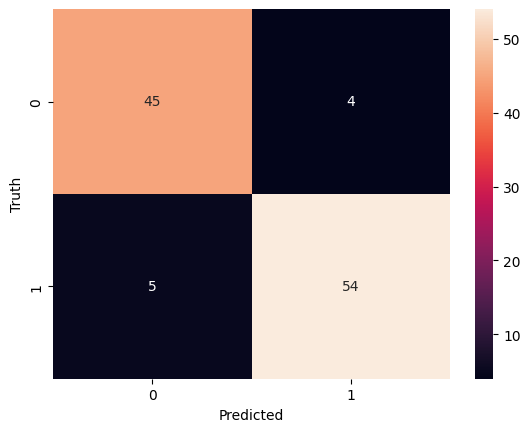

In [16]:
cm = confusion_matrix(test_y, test_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')